# Step 3-3 Multivariate DL models

Multivariate Deep Learning models.

The models are multivariate versions from the baseline models: LSTM, Bi-directional LSTM, ED-LSTM, CNN

**Data prep and train workflow**:

raw data -> split train and test -> pct_change normalisation -> combine all countries' train data -> fit universal StandardScaler

-> create sequences (5 input windows, 1 output window) -> train models with hyperparmeter tuning

**Test and evaluation workflow**:

for each country, combine train + test data (lags) -> calculate pct_change -> scale with the previous Scaler -> create sequences

-> Extract the last 9 sequences -> Model prediction -> Inverse StandardScaler -> Denormalise -> calculate metrics

The selected features from the previous feature selection step:

* Key features = `gdp`, `primary_energy_consumption`, `population`

* Selected features = `oil_production`, `nulcear_consumption`, `wind_consumption`, `biofuel_consumption`, `energy_per_gdp`



### Necessary imports

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Conv1D, Flatten
from keras.layers import RepeatVector, TimeDistributed, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import warnings
import os

warnings.filterwarnings("ignore")

### Config

In [81]:
TARGET_VARIABLES = 'co2'
SELECTED_COUNTRIES = ['United States', 'China', 'India']
MAX_LAGS = 4
N_STEPS_IN = 5
N_STEPS_OUT = 1
TEST_SIZE = 9
save_dir = 'data/03_03_results'
os.makedirs(save_dir, exist_ok=True)

DL_MODELS_ORDER = ['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']

MULTIVARIATE_FEATURES = [
    'gdp',
    'primary_energy_consumption',
    'population',
    'oil_production',
    'nuclear_consumption',
    'wind_consumption',
    'biofuel_consumption',
    'energy_per_gdp'
]

ARIMA_ORDERS = {
    'United States': (0, 1, 0),
    'China': (0, 2, 0),
    'India': (1, 1, 1)
}

### Hyperparameter Tuning Config

In [82]:
DL_CONFIGS = {
    'LSTM': [
        {'hidden': 16, 'epochs': 100, 'dropout': 0.0},
        {'hidden': 32, 'epochs': 100, 'dropout': 0.0},
        {'hidden': 64, 'epochs': 100, 'dropout': 0.2}
    ],
    'Bi-LSTM': [
        {'hidden': 8, 'epochs': 100, 'dropout': 0.0},
        {'hidden': 16, 'epochs': 100, 'dropout': 0.0},
        {'hidden': 32, 'epochs': 100, 'dropout': 0.2}
    ],
    'ED-LSTM': [
        {'hidden': 8, 'epochs': 100, 'dropout': 0.0},
        {'hidden': 16, 'epochs': 100, 'dropout': 0.0},
        {'hidden': 32, 'epochs': 100, 'dropout': 0.2}
    ],
    'CNN': [
        {'filters': 16, 'epochs': 100},
        {'filters': 32, 'epochs': 100},
        {'filters': 64, 'epochs': 100}
    ]
}

### Data Load

In [83]:
def load_data(save_dir='data'):
    data_files = {
        'all_data_df': os.path.join(save_dir, 'all_data_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(save_dir, 'lag_three_sel_1969_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [84]:
data = load_data()
all_data_df = data['all_data_df']
g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]
lag_three_sel_1969_df = data['lag_three_sel_1969_df']

Loaded all_data_df: (55529, 200)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)


### Data Prep

In [85]:
def tts_by_year(df, test_size=9):
    train_data = {}
    test_data = {}

    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')

        split_idx = len(country_data) - test_size
        train_data[country] = country_data.iloc[:split_idx]
        test_data[country] = country_data.iloc[split_idx:]

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [86]:
train_3_df, test_3_df = tts_by_year(lag_three_sel_1969_df, TEST_SIZE)
train_g20_df, test_g20_df = tts_by_year(g20_lag_1969_df, TEST_SIZE)

print(f"Train data shape: {train_3_df.shape}")
print(f"Test data shape: {test_3_df.shape}")

Train data shape: (135, 992)
Test data shape: (27, 992)


### Helper functions

In [87]:
def mase(y_actual, y_pred, period=1):
    mae_forecast = mean_absolute_error(y_actual, y_pred)

    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]

    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)

    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [88]:
def calculate_pct_change(df, features, max_lags=MAX_LAGS):
    df_copy = df.copy()
    df_copy = df_copy.sort_values(['country', 'year']).reset_index(drop=True)
    pct_change_cols = []

    for feature in features:
        if feature not in df_copy.columns:
            continue

        # Pct change on current values
        lag1_col = f"{feature}_lag1"
        if lag1_col in df_copy.columns:
            df_copy[f"{feature}_pct_change"] = ((df_copy[feature] - df_copy[lag1_col]) / df_copy[lag1_col] * 100)
            pct_change_cols.append(f"{feature}_pct_change")

        # Pct change on lagged values
        for lag in range(1, max_lags):
            lag_col = f"{feature}_lag{lag}"
            prev_lag_col = f"{feature}_lag{lag+1}"
            
            if lag_col in df_copy.columns and prev_lag_col in df_copy.columns:
                df_copy[f"{lag_col}_pct_change"] = ((df_copy[lag_col] - df_copy[prev_lag_col]) / df_copy[prev_lag_col] * 100)
                pct_change_cols.append(f"{lag_col}_pct_change")

        # Lag4 for the first row = 0, then shift lag3_pct by country
        last_lag_col = f"{feature}_lag{max_lags}"
        lag3_pct_col = f"{feature}_lag{max_lags-1}_pct_change"

        if last_lag_col in df_copy.columns and lag3_pct_col in df_copy.columns:
            df_copy[f"{last_lag_col}_pct_change"] = df_copy.groupby('country')[lag3_pct_col].shift(1).fillna(0)
            pct_change_cols.append(f"{last_lag_col}_pct_change")
            
        df_copy = df_copy.replace([np.inf, -np.inf], np.nan)
    
    return df_copy, pct_change_cols

In [89]:
def create_sequences(data, n_steps_in, n_features):
    X, y = [], []

    for i in range(len(data) - n_steps_in):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in, 0]) # Target co2 is the first column

    return np.array(X), np.array(y)

### Model Builds

In [90]:
def build_lstm(input_shape, hidden=16, dropout=0.0):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [91]:
def build_bilstm(input_shape, hidden=8, dropout=0.0):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                        input_shape=input_shape),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [92]:
def build_edlstm(input_shape, hidden=8, dropout=0.0):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(dropout),
        RepeatVector(N_STEPS_OUT),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [93]:
def build_cnn(input_shape, filters=16):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

### Model Train

In [94]:
# Data Prep
def prepare_train_data(train_df, features, target):
    all_train_pct_data = []
    country_train_info = {}

    for country in train_df['country'].unique():
        country_data = train_df[train_df['country'] == country].sort_values('year').reset_index(drop=True)

        # Caculate pct_change for all features
        country_pct, pct_cols = calculate_pct_change(country_data, features, MAX_LAGS)

        # pct_change values for all features
        feature_pct_values = []
        for feat in features:
            pct_col = f"{feat}_pct_change"
            if pct_col in country_pct.columns:
                pct_values = country_pct[pct_col].fillna(0).values
                feature_pct_values.append(pct_values)
            else:
                print(f"{pct_col} not in {country}")
        
        # Stacking features: shape (timesteps, n_features)
        feature_pct_array = np.column_stack(feature_pct_values)
        all_train_pct_data.append(feature_pct_array)
        
        country_train_info[country] = {
            'pct_values': feature_pct_array,
            'original_values': country_data[target].values,
            'years': country_data['year'].values
        }
        
        print(f"{country} pct_values shape: {feature_pct_array.shape}")
    
    return all_train_pct_data, country_train_info

In [95]:
all_train_pct_data, country_train_info = prepare_train_data(train_3_df, MULTIVARIATE_FEATURES, TARGET_VARIABLES)

China pct_values shape: (45, 8)
India pct_values shape: (45, 8)
United States pct_values shape: (45, 8)


In [96]:
# Fit universal StandardScaler
def fit_scaler(all_train_pct_data, features):
    all_train_pct_combined = np.vstack(all_train_pct_data)
    print(f"Combined train data shape: {all_train_pct_combined.shape}")

    scaler = StandardScaler()
    scaler.fit(all_train_pct_combined)

    for i, feat in enumerate(features):
        print(f"{feat} mean={scaler.mean_[i]:.4f}, std={np.sqrt(scaler.var_[i]):.4f}")

    return scaler

In [97]:
scaler = fit_scaler(all_train_pct_data, MULTIVARIATE_FEATURES)

Combined train data shape: (135, 8)
gdp mean=4.8601, std=3.1878
primary_energy_consumption mean=4.5367, std=4.6948
population mean=1.4430, std=0.5910
oil_production mean=3.7511, std=9.7537
nuclear_consumption mean=15.2010, std=72.4845
wind_consumption mean=2225.8822, std=25395.8016
biofuel_consumption mean=7.5562, std=22.1054
energy_per_gdp mean=-0.2989, std=3.5189


In [98]:
def create_train_sequences(country_train_info, scaler, features):
    X_train_all = []
    y_train_all = []

    for country, info in country_train_info.items():
        pct_values = info['pct_values']
        scaled_values = scaler.transform(pct_values)

        X_country, y_country = create_sequences(scaled_values, N_STEPS_IN, len(features))

        X_train_all.append(X_country)
        y_train_all.append(y_country)

        print(f"{country} X_train shape: {X_country.shape}, y_train shape: {y_country.shape}")
    
    X_train = np.vstack(X_train_all)
    y_train = np.concatenate(y_train_all)
    
    print(f"\nCombined training sequences:")
    print(f"    X_train shape: {X_train.shape}")
    print(f"    y_train shape: {y_train.shape}")
    
    return X_train, y_train

In [99]:
X_train, y_train = create_train_sequences(country_train_info, scaler, MULTIVARIATE_FEATURES)

China X_train shape: (40, 5, 8), y_train shape: (40,)
India X_train shape: (40, 5, 8), y_train shape: (40,)
United States X_train shape: (40, 5, 8), y_train shape: (40,)

Combined training sequences:
    X_train shape: (120, 5, 8)
    y_train shape: (120,)


In [100]:
# Train model and Tune hyperparameters
def train_model_and_tuning(X_train, y_train):
    dl_models = {
        'LSTM': build_lstm,
        'Bi-LSTM': build_bilstm,
        'ED-LSTM': build_edlstm,
        'CNN': build_cnn
    }

    trained_models = {}

    for model_name, model_func in dl_models.items():
        print(f"\nTraining {model_name}")

        best_val_loss = np.inf
        best_model = None
        best_config = None

        # Reshape y_train for ED-LSTM output shape (n_samples, n_steps_out, n_features)
        if model_name == 'ED-LSTM':
            y_train_model = y_train.reshape(-1, N_STEPS_OUT, 1)
            print(f"ED-LSTM target shape: {y_train_model.shape}")
        else:
            y_train_model = y_train
            print(f"{model_name} target shape: {y_train_model.shape}")

        for config in DL_CONFIGS[model_name]:
            epochs = config['epochs']
            config_params = {k: v for k, v in config.items() if k != 'epochs'}

            input_shape = (X_train.shape[1], X_train.shape[2])

            if model_name == 'CNN':
                model = model_func(input_shape, filters=config_params['filters'])
            else:
                model = model_func(input_shape, hidden=config_params['hidden'], dropout=config_params.get('dropout', 0.0))

            history = model.fit(X_train, y_train_model, epochs=epochs, batch_size=16, validation_split=0.1, verbose=0)

            val_loss = history.history['val_loss'][-1]
            print(f"    For config: {config}: val_loss = {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = config
            else:
                tf.keras.backend.clear_session()
                del model
        
        trained_models[model_name] = {
            'model': best_model,
            'config': best_config
        }
        
        print(f"\nBest {model_name} - config: {best_config}, val_loss: {best_val_loss:.4f}")
    
    return trained_models

In [101]:
trained_models = train_model_and_tuning(X_train, y_train)


Training LSTM
LSTM target shape: (120,)
    For config: {'hidden': 16, 'epochs': 100, 'dropout': 0.0}: val_loss = 0.7204
    For config: {'hidden': 32, 'epochs': 100, 'dropout': 0.0}: val_loss = 0.9824
    For config: {'hidden': 64, 'epochs': 100, 'dropout': 0.2}: val_loss = 0.9534

Best LSTM - config: {'hidden': 16, 'epochs': 100, 'dropout': 0.0}, val_loss: 0.7204

Training Bi-LSTM
Bi-LSTM target shape: (120,)
    For config: {'hidden': 8, 'epochs': 100, 'dropout': 0.0}: val_loss = 1.4213
    For config: {'hidden': 16, 'epochs': 100, 'dropout': 0.0}: val_loss = 0.9535
    For config: {'hidden': 32, 'epochs': 100, 'dropout': 0.2}: val_loss = 0.8934

Best Bi-LSTM - config: {'hidden': 32, 'epochs': 100, 'dropout': 0.2}, val_loss: 0.8934

Training ED-LSTM
ED-LSTM target shape: (120, 1, 1)
    For config: {'hidden': 8, 'epochs': 100, 'dropout': 0.0}: val_loss = 1.0455
    For config: {'hidden': 16, 'epochs': 100, 'dropout': 0.0}: val_loss = 1.0338
    For config: {'hidden': 32, 'epochs': 

In [102]:
# Evaluation
def eval_on_test(train_df, test_df, target, features, scaler, trained_models, selected_countries):
    all_results = {}

    for country in selected_countries:
        print(f"{country.upper()}")

        train_country = train_df[train_df['country'] == country].sort_values('year').reset_index(drop=True)
        test_country = test_df[test_df['country'] == country].sort_values('year').reset_index(drop=True)

        combined_data = pd.concat([train_country, test_country], ignore_index=True)

        # Calculating pct_change for combined data
        combined_pct, _ = calculate_pct_change(combined_data, features, MAX_LAGS)

        # Stack pct_change values for all features
        feature_pct_values = []
        for feat in features:
            pct_col = f"{feat}_pct_change"
            if pct_col in combined_pct.columns:
                pct_values = combined_pct[pct_col].fillna(0).values
                feature_pct_values.append(pct_values)

        stacked_combined_pct = np.column_stack(feature_pct_values)
        
        # Fit the StandardScaler used before
        combined_scaled = scaler.transform(stacked_combined_pct)

        # Original values for calculating errors
        original_values = combined_data[target].values

        X_all, y_all = create_sequences(combined_scaled, N_STEPS_IN, len(features))

        X_test = X_all[-TEST_SIZE:]
        test_years = test_country['year'].values

        print(f"Test sequence shape: {X_test.shape}")

        country_results = {}

        for model_name, model_info in trained_models.items():
            model = model_info['model']
            config = model_info['config']

            # The model predicts scaled values due to the scaled train data
            preds_scaled = model.predict(X_test, verbose=0)

            # Flatten for ED-LSTM 3D output (n_samples, n_steps_out, features)
            if len(preds_scaled.shape) == 3:
                preds_scaled = preds_scaled[:, 0, 0]
            else:
                # Others flatten with ravel
                preds_scaled = preds_scaled.ravel()

            # Inverse transform co2 (first feature)
            tmp_array = np.zeros((len(preds_scaled), len(features)))
            tmp_array[:, 0] = preds_scaled
            preds_pct_inverse = scaler.inverse_transform(tmp_array)
            preds_pct_change = preds_pct_inverse[:, 0]

            # Denormalise pct change to forecasted actual CO2 values
            forecast = []
            test_start_idx = len(original_values) - TEST_SIZE

            for i in range(TEST_SIZE):
                prev_value = original_values[test_start_idx + i - 1]
                predicted_value = prev_value * (1 + preds_pct_change[i] / 100)
                forecast.append(predicted_value)

            forecast = np.array(forecast)
            actual_test = original_values[-TEST_SIZE:]
            
            # Calculate metrics
            individual_errors = np.abs(actual_test - forecast)
            rmse_score = np.sqrt(mean_squared_error(actual_test, forecast))
            mase_score = mase(actual_test, forecast)

            country_results[model_name] = {
                'forecast': forecast,
                'actual': actual_test,
                'individual_errors': individual_errors,
                'test_years': test_years,
                'RMSE': rmse_score,
                'MASE': mase_score,
                'best_config': config
            }

            print(f"\n  {model_name}")
            print(f"    RMSE: {rmse_score:.4f}")
            print(f"    MASE: {mase_score:.4f}")
            print(f"    Config: {config}")
        
        all_results[country] = country_results
    
    return all_results

In [103]:
dl_results = eval_on_test(train_3_df, test_3_df, TARGET_VARIABLES, MULTIVARIATE_FEATURES,
                          scaler, trained_models, SELECTED_COUNTRIES)

UNITED STATES
Test sequence shape: (9, 5, 8)

  LSTM
    RMSE: 361.7046
    MASE: 1.6009
    Config: {'hidden': 16, 'epochs': 100, 'dropout': 0.0}

  Bi-LSTM
    RMSE: 353.4247
    MASE: 1.5494
    Config: {'hidden': 32, 'epochs': 100, 'dropout': 0.2}

  ED-LSTM
    RMSE: 398.8341
    MASE: 1.7413
    Config: {'hidden': 32, 'epochs': 100, 'dropout': 0.2}

  CNN
    RMSE: 358.2634
    MASE: 1.5640
    Config: {'filters': 16, 'epochs': 100}
CHINA
Test sequence shape: (9, 5, 8)

  LSTM
    RMSE: 647.5311
    MASE: 2.2973
    Config: {'hidden': 16, 'epochs': 100, 'dropout': 0.0}

  Bi-LSTM
    RMSE: 588.8986
    MASE: 2.1080
    Config: {'hidden': 32, 'epochs': 100, 'dropout': 0.2}

  ED-LSTM
    RMSE: 620.8830
    MASE: 2.1878
    Config: {'hidden': 32, 'epochs': 100, 'dropout': 0.2}

  CNN
    RMSE: 589.0822
    MASE: 2.0626
    Config: {'filters': 16, 'epochs': 100}
INDIA
Test sequence shape: (9, 5, 8)

  LSTM
    RMSE: 159.6863
    MASE: 0.8467
    Config: {'hidden': 16, 'epochs': 100,

### Summary Table

In [104]:
summary_data = []

for country in SELECTED_COUNTRIES:
    for model_name, result in dl_results[country].items():
        summary_data.append({
            'Country': country,
            'Model': model_name,
            'RMSE': result['RMSE'],
            'MASE': result['MASE']
        })

summary_df = pd.DataFrame(summary_data)

# RMSE pivot table
rmse_pivot = summary_df.pivot(index='Model', columns='Country', values='RMSE')
rmse_pivot = rmse_pivot.round(4)

# Ordering models
rmse_pivot = rmse_pivot.reindex([m for m in DL_MODELS_ORDER if m in rmse_pivot.index])

print(rmse_pivot)

Country     China     India  United States
Model                                     
LSTM     647.5311  159.6863       361.7046
Bi-LSTM  588.8986  150.4883       353.4247
ED-LSTM  620.8830  168.6096       398.8341
CNN      589.0822  156.9280       358.2634


In [105]:
# MASE pivot table
mase_pivot = summary_df.pivot(index='Model', columns='Country', values='MASE')
mase_pivot = mase_pivot.round(4)

# Ordering models
mase_pivot = mase_pivot.reindex([m for m in DL_MODELS_ORDER if m in mase_pivot.index])

print(mase_pivot)

Country   China   India  United States
Model                                 
LSTM     2.2973  0.8467         1.6009
Bi-LSTM  2.1080  0.7862         1.5494
ED-LSTM  2.1878  0.8902         1.7413
CNN      2.0626  0.7720         1.5640


In [106]:
pivot_table_filepath = os.path.join(save_dir, 'Multi_DL_summary.md')
with open(pivot_table_filepath, 'w') as f:
    f.write("# Summary of Multivariate DL models\n\n")
    f.write("RMSE of each DL model trained on all countries combined dataset with selected features for 3 countries\n\n")
    f.write(rmse_pivot.to_markdown())
    f.write("\n\n")

    f.write("---\n\n")

    f.write("MASE of each DL model trained on all countries combined dataset with selected features for 3 countries\n\n")
    f.write(mase_pivot.to_markdown())
    f.write("\n\n")

### Individual Errors

In [107]:
for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    test_years = dl_results[country]['LSTM']['test_years']
    
    for model_name in DL_MODELS_ORDER:
        if model_name in dl_results[country]:
            print(f"\n{model_name}")

            forecast = dl_results[country][model_name]['forecast']
            actual = dl_results[country][model_name]['actual']
            ind_errors = dl_results[country][model_name]['individual_errors']

            for i in range(TEST_SIZE):
                print(f"    {test_years[i]}: Error={ind_errors[i]:.4f}, Actual={actual[i]:.4f}, Forecast={forecast[i]:.4f}")


UNITED STATES

LSTM
    2014: Error=202.7720, Actual=5528.6810, Forecast=5731.4530
    2015: Error=410.4631, Actual=5376.4730, Forecast=5786.9361
    2016: Error=323.5833, Actual=5252.9320, Forecast=5576.5153
    2017: Error=222.2774, Actual=5212.1620, Forecast=5434.4394
    2018: Error=17.9889, Actual=5377.7970, Forecast=5395.7859
    2019: Error=387.3340, Actual=5262.1450, Forecast=5649.4790
    2020: Error=764.4762, Actual=4714.6280, Forecast=5479.1042
    2021: Error=233.7173, Actual=5032.2130, Forecast=4798.4957
    2022: Error=156.0873, Actual=5078.8710, Forecast=5234.9583

Bi-LSTM
    2014: Error=156.4529, Actual=5528.6810, Forecast=5685.1339
    2015: Error=383.3238, Actual=5376.4730, Forecast=5759.7968
    2016: Error=334.3716, Actual=5252.9320, Forecast=5587.3036
    2017: Error=259.8235, Actual=5212.1620, Forecast=5471.9855
    2018: Error=7.4158, Actual=5377.7970, Forecast=5385.2128
    2019: Error=337.2864, Actual=5262.1450, Forecast=5599.4314
    2020: Error=763.0578, Ac

In [108]:
ind_errors_data = []

for country in SELECTED_COUNTRIES:
    test_years = dl_results[country]['LSTM']['test_years']

    for model_name in DL_MODELS_ORDER:
        if model_name in dl_results[country]:
            individual_errors = dl_results[country][model_name]['individual_errors']
            
            for i in range(TEST_SIZE):
                ind_errors_data.append({
                    'Country': country,
                    'Model': model_name,
                    'Year': test_years[i],
                    'Error': individual_errors[i]
                })

ind_errors_df = pd.DataFrame(ind_errors_data)

# Save
with open(pivot_table_filepath, 'w') as f:
    f.write("# Individual step errors for each model for each country\n\n")
    f.write("Each step's errors are calculated with RMSE and MASE for 3 countries\n\n")
    f.write(ind_errors_df.to_markdown())
    f.write("\n\n")

### Visualisation of forecasts

In [109]:
print("Type of dl_results:", type(dl_results))
print("\nKeys in dl_results:", dl_results.keys() if isinstance(dl_results, dict) else "Not a dict")

if isinstance(dl_results, dict):
    for country in SELECTED_COUNTRIES:
        if country in dl_results:
            print(f"\n{country}:")
            print(f"  Keys: {dl_results[country].keys()}")

Type of dl_results: <class 'dict'>

Keys in dl_results: dict_keys(['United States', 'China', 'India'])

United States:
  Keys: dict_keys(['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN'])

China:
  Keys: dict_keys(['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN'])

India:
  Keys: dict_keys(['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN'])



Creating plot for UNITED STATES

Creating plot for CHINA

Creating plot for INDIA


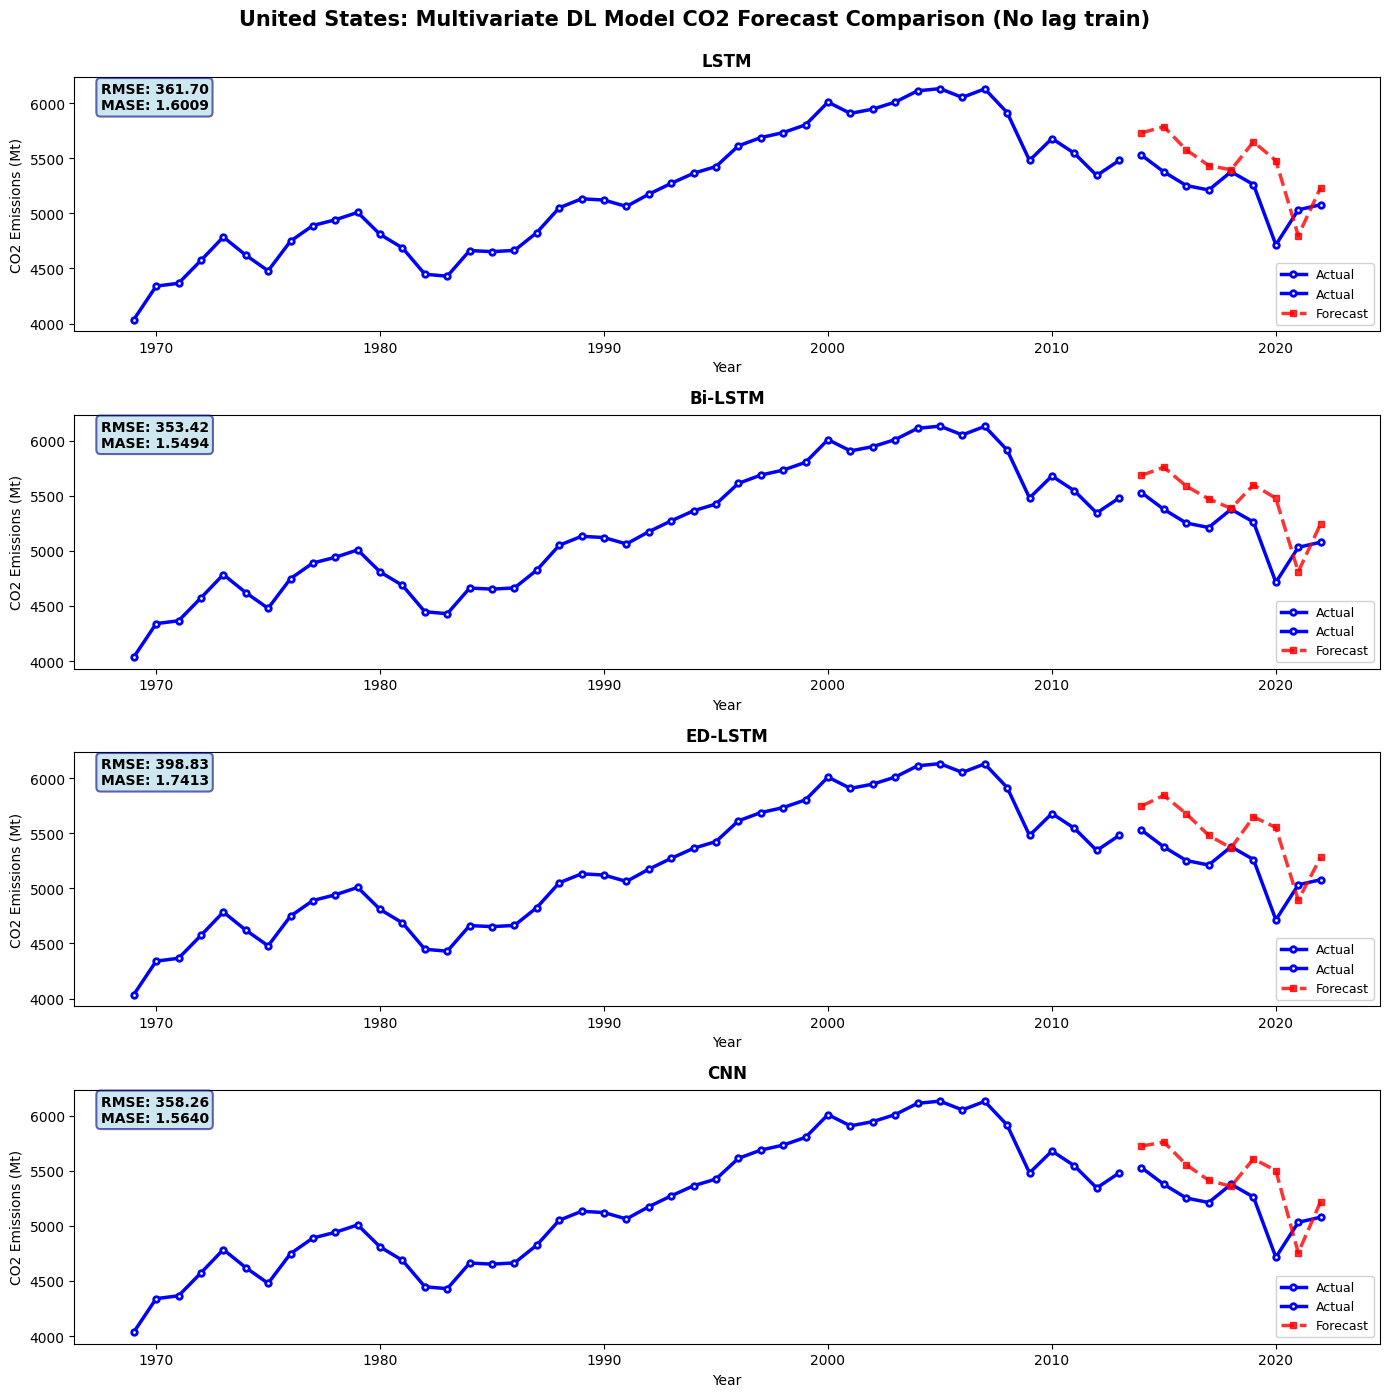

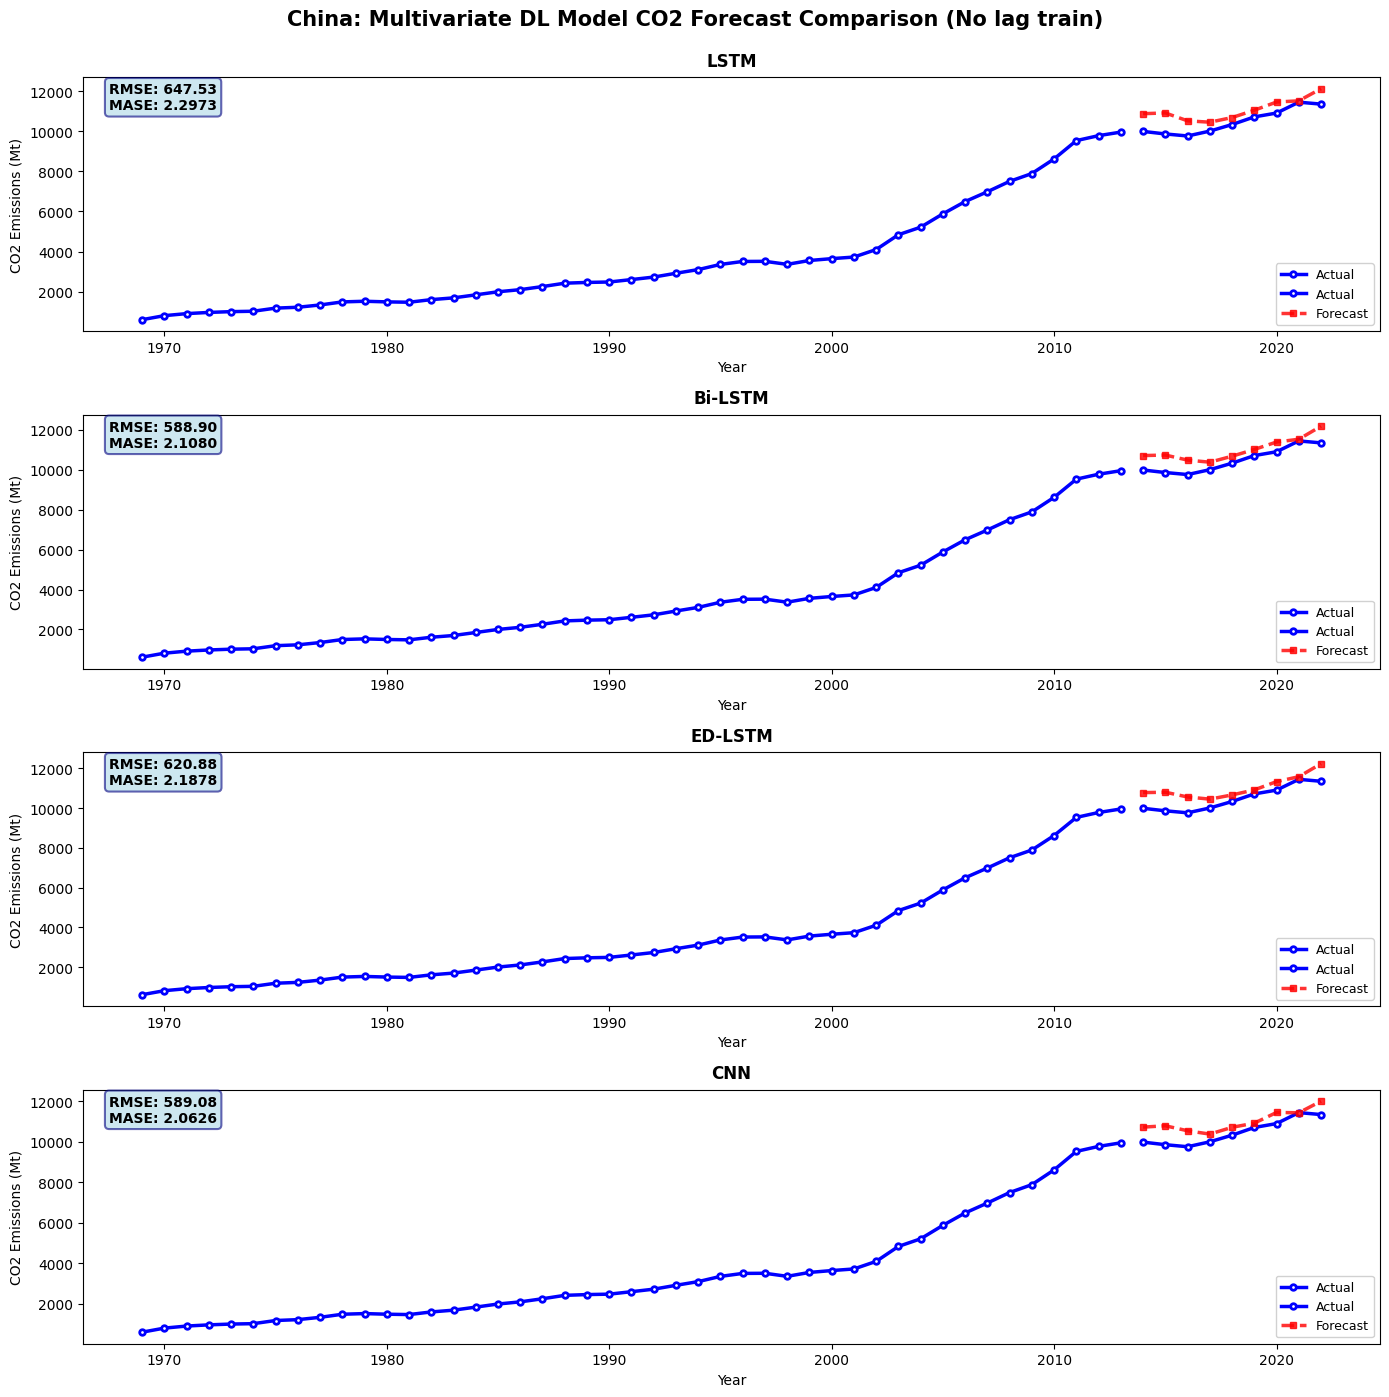

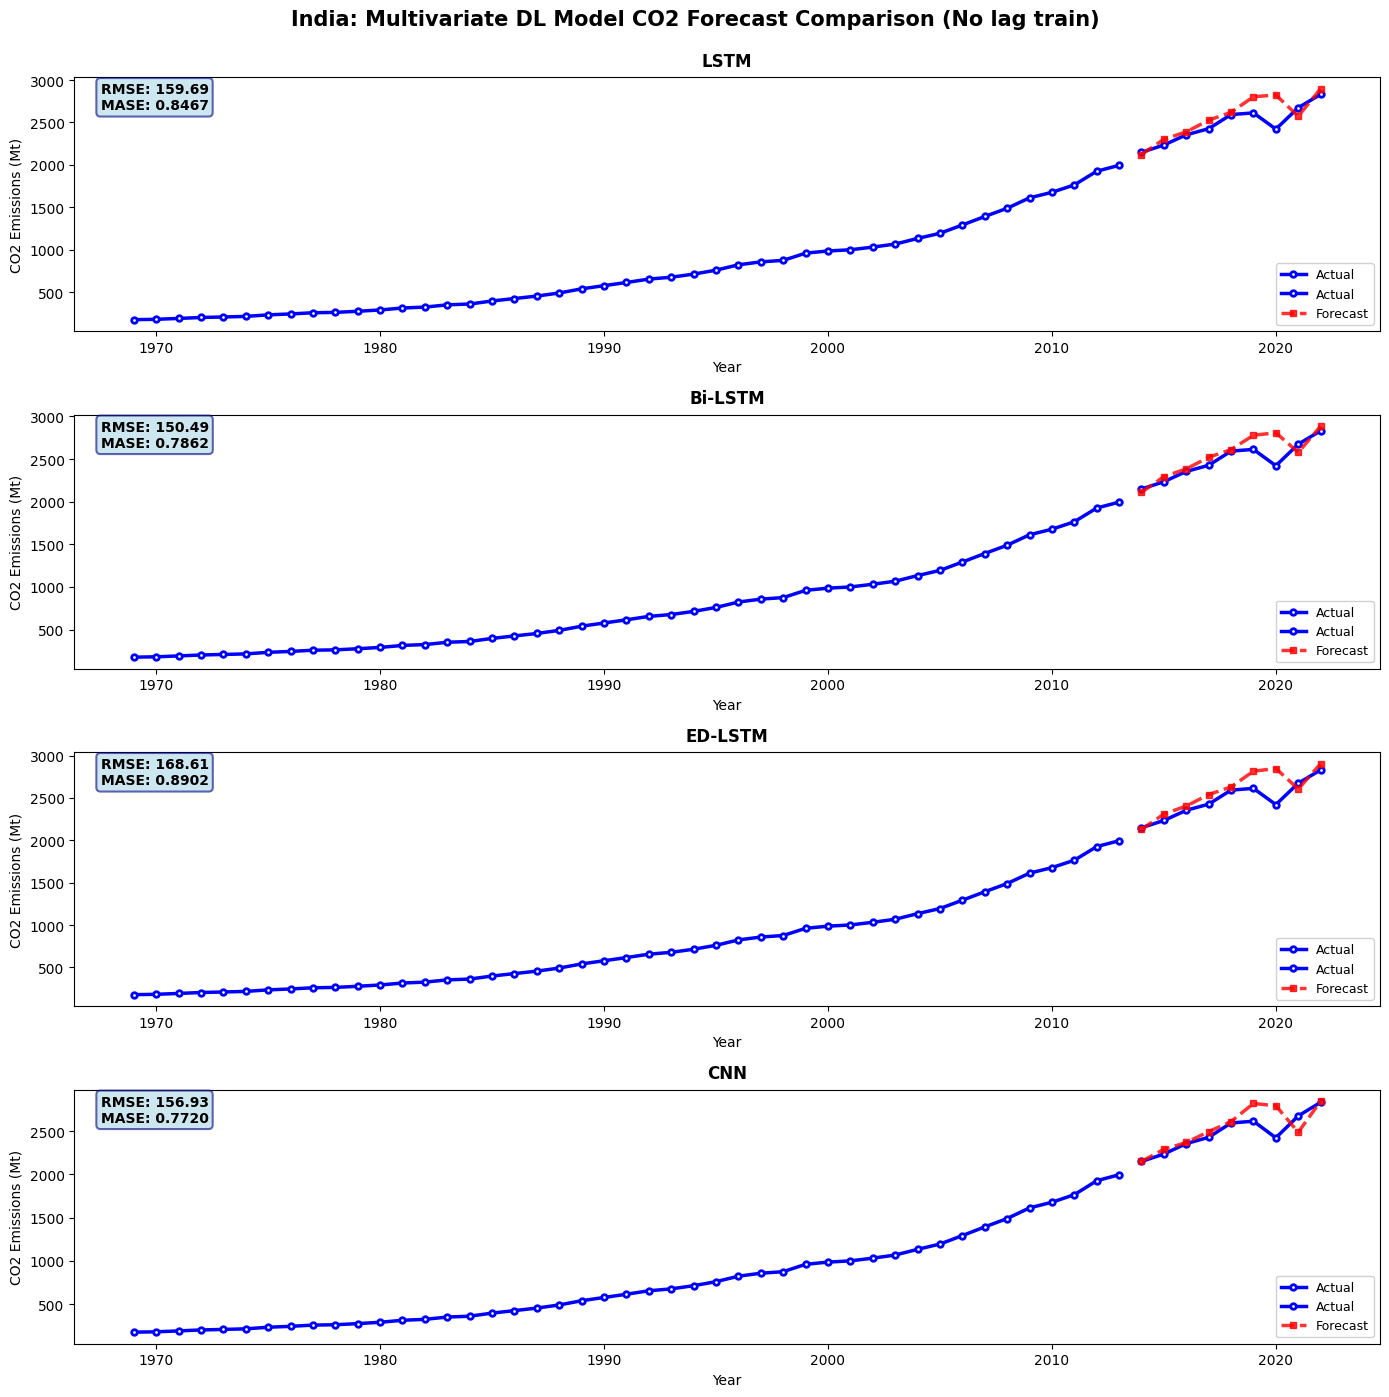

In [110]:
colors = {'actual': 'blue', 'forecast': 'red'}

for country in SELECTED_COUNTRIES:
    print(f"\nCreating plot for {country.upper()}")
     
    train_country = train_3_df[train_3_df['country'] == country].sort_values('year')
    test_country = test_3_df[test_3_df['country'] == country].sort_values('year')

    fig, axes = plt.subplots(4, 1, figsize=(14, 14))

    for idx, model_name in enumerate(DL_MODELS_ORDER):
        ax = axes[idx]

        # Plot train data
        ax.plot(train_country['year'], train_country[TARGET_VARIABLES], color=colors['actual'], linewidth=2.5,
                label='Actual', marker='o', markersize=4, markerfacecolor='white', markeredgewidth=2,
                markeredgecolor=colors['actual'])
        
        # Plot test actual data
        ax.plot(test_country['year'], test_country[TARGET_VARIABLES], color=colors['actual'], linewidth=2.5,
                label='Actual', marker='o', markersize=4, markerfacecolor='white', markeredgewidth=2,
                markeredgecolor=colors['actual'])
        
        # Plot forecast data
        if model_name in dl_results[country]:
            result = dl_results[country][model_name]
            forecast = result['forecast']
            rmse_score = result['RMSE']
            mase_score = result['MASE']
            test_years = result['test_years']

            ax.plot(test_years, forecast, color=colors['forecast'], linewidth=2.5,
                        linestyle='--', label='Forecast', marker='s', markersize=4, alpha=0.8)

            metrics_str = f"RMSE: {rmse_score:.2f}\nMASE: {mase_score:.4f}"
            props = dict(boxstyle='round', facecolor='lightblue', alpha=0.6, edgecolor='navy', linewidth=1.5)
            ax.text(0.02, 0.98, metrics_str, transform=ax.transAxes, fontsize=10, verticalalignment='top',
                        bbox=props, fontweight='bold')
        else:
             print("    Forecast not found")
            
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold', pad=8)
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel('CO2 Emissions (Mt)', fontsize=10)
        ax.legend(loc='lower right', fontsize=9, framealpha=0.9)

    plt.suptitle(f'{country}: Multivariate DL Model CO2 Forecast Comparison (No lag train)', 
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()

    # Save
    plot_filename = f"{country.replace(' ', '_')}_multivariate_model_comparison.png"
    plot_filepath = os.path.join(save_dir, plot_filename)
    plt.savefig(plot_filepath, dpi=150, bbox_inches='tight')